## **Notebook Content**

In this notebook the following tasks are performed :  


*   Data Augumentation
*   Data Preprocessing
*   Model Configuration Parameters
*   Model Data Generation
*   Model Construction
*   Model Training
*   Model Ealuating
*   Model Optimization
*   Confusion Matrix Plotting
*   Classification Report Plotting











## **Loading the Libaries**

In [ ]:
pip install keras-tuner

In [32]:
import cv2
import os
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras import layers
from tensorflow import keras
from tensorflow.keras.optimizers import Adam
from tensorflow.python.keras.utils.data_utils import Sequence
from tensorflow.keras import backend as K
import tensorflow as tf
from tensorflow.keras.applications import DenseNet201, DenseNet121
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential,Model,load_model
from tensorflow.keras.layers import Convolution2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Flatten,Dense,Activation,Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau,ModelCheckpoint,Callback
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.metrics import AUC,Precision, Recall, categorical_crossentropy,  top_k_categorical_accuracy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.mobilenet import preprocess_input as dense_preprocess_input
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt
import pandas as pd
import shutil
from kerastuner.tuners import RandomSearch
from kerastuner.engine.hyperparameters import HyperParameters
import keras_tuner

In [1]:
# MOUNTING THE DRIVE
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [27]:
import zipfile
zip_ref = zipfile.ZipFile("/content/drive/My Drive/processed_datasets.zip", 'r')
zip_ref.extractall("/content")
zip_ref.close()

In [28]:
%cd /content/processed_datasets-20231209T225815Z-001/processed_datasets

/content/processed_datasets-20231209T225815Z-001/processed_datasets


In [29]:
# Define paths for Training and Testing Data
train_path = "train_dir"
valid_path = "val_dir"

In [30]:
# Assuming the CSV files are in the current working directory or provide the full path
train_csv_path = "/content/drive/My Drive/skincancer/processed_datasets/traincsv.csv"
valid_csv_path = "/content/drive/My Drive/skincancer/processed_datasets/validcsv.csv"

# Read CSV files into DataFrames
df_train = pd.read_csv(train_csv_path)
df_val= pd.read_csv(valid_csv_path)

## **Creating Pipelines**


## **Preprocessing Function for Data Augumentation**

In [ ]:
# Preprocessing for Augmentation

# Note: Augmentation is not applied to the class 'nv'

# Specify the classes for which augmentation will be performed
class_list = ['vasc', 'df']

# Iterate through each class for augmentation
for item in class_list:

    # Create an augmentation directory
    aug_dir = 'aug_dir'
    os.mkdir(aug_dir)

    # Create a subdirectory to store augmented images
    img_dir = os.path.join(aug_dir, 'img_dir')
    os.mkdir(img_dir)

    # Choose a specific class for augmentation
    img_class = item

    # List all images in the class training directory
    img_list = os.listdir('processed_datasets/train_dir/' + img_class)

    # Copy images from the class training directory to the augmentation directory
    for fname in img_list:
        # Source path to the image
        src = os.path.join('processed_datasets/train_dir/' + img_class, fname)
        # Destination path to the image in the augmentation directory
        dst = os.path.join(img_dir, fname)
        # Copy the image from the source to the destination
        shutil.copyfile(src, dst)

    # Set the path to the directory containing the images for augmentation
    path = aug_dir
    # Set the save path to the original training directory for the specific class
    save_path = 'processed_datasets/train_dir/' + img_class

    # Create a data generator for image augmentation
    datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=180,
        width_shift_range=0.1,
        height_shift_range=0.1,
        zoom_range=0.1,
        horizontal_flip=True,
        vertical_flip=True,
        fill_mode='nearest')

    # Set the batch size for the data generator
    batch_size = 50

    # Create an augmented data generator
    aug_datagen = datagen.flow_from_directory(
        path,
        save_to_dir=save_path,
        save_format='jpg',
        target_size=(224,224),
        batch_size=batch_size)

    # Generate augmented images and add them to the original training folder
    num_aug_images_wanted = 6000  # Total number of images desired in each class

    num_files = len(os.listdir(img_dir))
    num_batches = int(np.ceil((num_aug_images_wanted - num_files) / batch_size))

    # Run the generator to create approximately 6000 augmented images
    for i in range(0, num_batches):
        imgs, labels = next(aug_datagen)

    # Delete the temporary directory with the raw image files
    shutil.rmtree('aug_dir')

In [5]:
print(len(os.listdir('/content/drive/My Drive/skincancer/processed_datasets/train_dir/nv')))
print(len(os.listdir('/content/drive/My Drive/skincancer/processed_datasets/train_dir/mel')))
print(len(os.listdir('/content/drive/My Drive/skincancer/processed_datasets/train_dir/bkl')))
print(len(os.listdir('/content/drive/My Drive/skincancer/processed_datasets/train_dir/bcc')))
print(len(os.listdir('/content/drive/My Drive/skincancer/processed_datasets/train_dir/akiec')))
print(len(os.listdir('/content/drive/My Drive/skincancer/processed_datasets/train_dir/vasc')))
print(len(os.listdir('/content/drive/My Drive/skincancer/processed_datasets/train_dir/df')))

5954
6020
6020
5858
4812
5290
4410


## **Preprocessing Function for Data Generation**

In [34]:
def data_generator(seed, train_path, valid_path, image_resize, train_batch_size, pretrained_model, validation_batch_size):
    """
    Generate data generators for training, validation, and testing.

    Parameters:
    - seed: Seed for random operations.
    - train_path: Path to the training dataset.
    - valid_path: Path to the validation dataset.
    - image_resize: Tuple specifying the target size for images.
    - train_batch_size: Batch size for the training generator.
    - pretrained_model: Pretrained model for preprocessing.
    - validation_batch_size: Batch size for the validation generator.

    Returns:
    - train_generator: Data generator for training images.
    - validation_generator: Data generator for validation images.
    - test_generator: Data generator for testing images.
    """

    # Initialize ImageDataGenerator for training data
    datagen = ImageDataGenerator(
        preprocessing_function=dense_preprocess_input,
    )

    # Flow training images using train_datagen generator
    train_generator = datagen.flow_from_directory(
        directory=train_path,
        target_size=image_resize,
        batch_size=train_batch_size,
    )

    # Flow validation images using valid_datagen generator
    validation_generator = datagen.flow_from_directory(
        directory=valid_path,
        target_size=image_resize,
        batch_size=validation_batch_size,
    )

    # Flow test images using datagen generator without shuffling
    test_generator = datagen.flow_from_directory(
        directory=valid_path,
        target_size=image_resize,
        batch_size=1,
        shuffle=False
    )

    return train_generator, validation_generator, test_generator

## **Model Configuration and Hyperparameter Setup**



**Pre-trained model selection :  DenseNet121**

Selecting the right pre-trained model or algorithm is crucial for achieving optimal performance in a specific problem domain. In the context of this project, DenseNet121 can be justified as a suitable choice for our algorithm for several reasons:

**Transfer Learning Capability:** DenseNet121 is a deep convolutional neural network (CNN) that has been pre-trained on a large-scale dataset (ImageNet). Transfer learning allows the model to leverage knowledge gained from this diverse dataset, capturing generic image features. This is particularly beneficial when working with medical images, as features learned from general images can be relevant to identifying patterns in skin lesions.

**Architectural Design:** DenseNet stands out for its unique architecture, where each layer receives feature maps from all preceding layers. This dense connectivity enhances feature reuse and information flow throughout the network, promoting better gradient flow during training. This architectural design often leads to improved convergence and better generalization, which is essential for accurate skin cancer classification.

**Performance in Medical Imaging:** DenseNet architectures have demonstrated success in various medical imaging tasks, showcasing their ability to extract relevant features from complex images. The model's ability to capture hierarchical and fine-grained patterns makes it a strong candidate for distinguishing between different types of skin lesions.

**Community Adoption and Benchmarking:** DenseNet121 is widely adopted and benchmarked in the machine learning community. Its performance has been well-documented in various image classification competitions and datasets. Leveraging a pre-trained model that has demonstrated success in similar tasks provides a strong foundation for building an effective skin cancer classification system.

Please refer to the [**README**](https://github.com/Moyo-tech/DermDetect-AI/blob/main/README.md#cnn-architecture-design) for more details

In [52]:

def model_parameter(selected_model):
    """
    Define hyperparameters and settings for the selected model.

    Parameters:
    - selected_model: Name of the selected model.

    Returns:
    - Dictionary containing hyperparameters and settings for the selected model.
    """

    # Dictionary containing model configurations
    model_list = {
        "DenseNet121": {
            "backbone": DenseNet121,
            "target": 7,
            "resize": 224,
            "epochs": 15,
            'train_batch_size': 10,
            'validation_batch_size': 10,
            'print_hyper_parameter': True,
            'input_image_size': 224,
        },
        # Add more models as needed
    }

    return model_list[selected_model]

In [53]:
# Select model to train
model_config = 'DenseNet121'

# Get the model parameters
selected_model = model_parameter(model_config)

In [54]:
# Hyperparameters and training settings for the model
hyper_param = {
    'seed': 42,  # Random seed for reproducibility
    'image_size': selected_model['resize'],  # Resize dimensions for input images
    'backbone_model': selected_model['backbone'],  # Pretrained model architecture (e.g., EfficientNetB4)
    'early_stop': 10,  # Number of epochs for early stopping
    'num_class': selected_model['target'],  # Number of target classes
    'train_batch_size': selected_model['train_batch_size'],  # Batch size for training
    'test_batch_size': 1,  # Batch size for testing
    'validation_batch_size': selected_model['validation_batch_size'],  # Batch size for validation
    'epoch': selected_model['epochs'],  # Number of training epochs
}

In [55]:
# Define the image size for resizing
image_resize = (hyper_param['image_size'], hyper_param['image_size'])
# Define the complete image shape including the number of channels (3 for RGB)
image_shape = image_resize + (3, )

In [56]:
image_resize

(224, 224)

In [57]:
# Print Hyper parameter
import pprint

if selected_model['print_hyper_parameter']:
    print("\n##   Hyper Parameter  ##\n")
    pprint.pprint(hyper_param)

    print('\nImage Shape: {}'.format(image_shape))



##   Hyper Parameter  ##

{'backbone_model': <function DenseNet121 at 0x7cde91751360>,
 'early_stop': 10,
 'epoch': 15,
 'image_size': 224,
 'num_class': 7,
 'seed': 42,
 'test_batch_size': 1,
 'train_batch_size': 10,
 'validation_batch_size': 10}

Image Shape: (224, 224, 3)


### **Calling Pipelines for the BASELINE MODEL**



In [35]:
# Generate Data Generators

# Use the data_generator function to create generators for training, validation, and testing data
train_generator, validation_generator, test_generator= data_generator(seed=hyper_param['seed'],
                                                                  valid_path=valid_path,
                                                                  train_path=train_path,
                                                                  pretrained_model=hyper_param['backbone_model'],
                                                                  image_resize=image_resize,
                                                                  train_batch_size=selected_model['train_batch_size'],
                                                                  validation_batch_size=selected_model['validation_batch_size'])

Found 38364 images belonging to 7 classes.
Found 938 images belonging to 7 classes.
Found 938 images belonging to 7 classes.


### **Create the Model**

In [60]:
# Baseline Model Construction with Feature Extraction

def baseline_model(input_size, num_classess, pretrained_model, lr_rate, dropout_rate, print_trainable_layers= False, print_model_summary= False):
    """
    Build a baseline model for image classification with feature extraction.

    Parameters:
    - input_size: Tuple specifying the input size of images.
    - num_classes: Number of classes for the classification task.
    - pretrained_model: Pretrained model architecture (e.g., DenseNet121).
    - model_name: Name of the model.
    - lr_rate: Learning rate for the optimizer.
    - dropout_rate: Dropout rate for regularization.
    - print_trainable_layers: Option to print trainable layers of the base model.
    - print_model_summary: Option to print the model summary.

    Returns:
    - Compiled Keras model for image classification with feature extraction.
    """
    # Load the pretrained model with imagenet weights and exclude the top classification layer
    base_model = pretrained_model(
        weights='imagenet',
        input_shape = input_size,
        include_top = False)

    # Build the Sequential model
    model = Sequential()

    # Add the pretrained base model for feature extraction
    model.add(base_model)

    # Add Global Average Pooling 2D layer for feature summarization
    model.add(layers.GlobalAveragePooling2D())

    # Add Dropout layer for regularization
    model.add(layers.Dropout(dropout_rate))

    # Add Dense layer for classification with softmax activation
    model.add(layers.Dense(num_classess, activation='softmax'))

    return model

In [61]:
# Create Baseline Model Instance

# Create an instance of the baseline model with specified parameters
baseline_model = baseline_model(
                        input_size=image_shape,
                        num_classess=hyper_param['num_class'],
                        pretrained_model=hyper_param['backbone_model'],
                        lr_rate= 0.001,
                        dropout_rate= 0.5)

29084464/29084464 [==============================] - 2s 0us/step


In [ ]:
# Define custom metrics
def top_3_accuracy(y_true, y_pred):
  return top_k_categorical_accuracy(y_true, y_pred, k=3)

def top_2_accuracy(y_true, y_pred):
  return top_k_categorical_accuracy(y_true, y_pred, k=2)

# Initialise the optimizer and compile the model with metrics
optimizer = Adam(learning_rate=0.001)
baseline_model.compile(optimizer= optimizer, loss='categorical_crossentropy', metrics=['categorical_accuracy', top_2_accuracy, top_3_accuracy, Precision(), Recall()])

In [ ]:
baseline_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet121 (Functional)    (None, 7, 7, 1024)        7037504   
                                                                 
 global_average_pooling2d (  (None, 1024)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 dense (Dense)               (None, 7)                 7175      
                                                                 
Total params: 7044679 (26.87 MB)
Trainable params: 6961031 (26.55 MB)
Non-trainable params: 83648 (326.75 KB)
_________________________________________________________________


In [ ]:
save_model_path = '/content/drive/My Drive/skincancer/finaltrain/basemodel121.h5'

# Configure ModelCheckpoint to save the best model based on validation top-3 accuracy
ck = ModelCheckpoint(save_model_path, monitor='val_top_3_accuracy', verbose=1, save_best_only=True, mode='max')

# Callback list
call_backs = [ck]

In [ ]:
class_weights = {
    0: 1.0, #akiec
    1: 1.0, #bcc
    2: 1.0, #bkl
    3: 1.0, #df
    4: 2.0, #melanoma increase weights for melanoma so it can classify it better
    5: 1.0, #nv
    6: 1.0, #vasc
}

In [ ]:
# Calculate Train and Validation Step Sizes

# Get the number of samples in the training and validation sets
num_train_samples = len(df_train)
num_val_samples = len(df_val)

# Define batch sizes and image size
train_batch_size = 10
val_batch_size = 10
image_size = 224

# Calculate step sizes for training and validation
STEP_SIZE_TRAIN =  np.ceil(num_train_samples / train_batch_size)
STEP_SIZE_VALID =  np.ceil(num_val_samples / train_batch_size)

### **Train the Model**

In [ ]:
# Train the Baseline Model
# Use the fit method to train the baseline model

baseline_history = baseline_model.fit(
                      train_generator,
                      epochs=15,
                      validation_data=validation_generator,
                      class_weight=class_weights,
                      steps_per_epoch=STEP_SIZE_TRAIN,
                      validation_steps=STEP_SIZE_VALID,
                      callbacks=call_backs,
                      verbose = 1,
)

Epoch 1/15
908/908 [==============================] - ETA: 0s - loss: 0.8388 - categorical_accuracy: 0.7185 - top_2_accuracy: 0.8911 - top_3_accuracy: 0.9608 - precision_1: 0.7830 - recall_1: 0.6464
Epoch 1: val_top_3_accuracy improved from -inf to 0.97655, saving model to /content/drive/My Drive/skincancer/finaltrain/basemodel121.h5
908/908 [==============================] - 122s 134ms/step - loss: 0.8388 - categorical_accuracy: 0.7185 - top_2_accuracy: 0.8911 - top_3_accuracy: 0.9608 - precision_1: 0.7830 - recall_1: 0.6464 - val_loss: 0.4215 - val_categorical_accuracy: 0.8678 - val_top_2_accuracy: 0.9403 - val_top_3_accuracy: 0.9765 - val_precision_1: 0.8940 - val_recall_1: 0.8539
Epoch 2/15
908/908 [==============================] - ETA: 0s - loss: 0.8309 - categorical_accuracy: 0.7231 - top_2_accuracy: 0.8933 - top_3_accuracy: 0.9612 - precision_1: 0.7870 - recall_1: 0.6502
Epoch 2: val_top_3_accuracy improved from 0.97655 to 0.97868, saving model to /content/drive/My Drive/skinca

In [ ]:
from tensorflow.keras.models import load_model
import pickle

# Save the training history of the Baseline model using pickle
with open('/content/drive/My Drive/skincancer/finaltrain/base_training_history121.pkl', 'wb') as file:
    pickle.dump(baseline_history.history, file)


### **Evaluate the baseline model**

In [ ]:

save_model_path = '/content/drive/My Drive/skincancer/finaltrain/basemodel121.h5'

custom_metrics = {
    'top_2_accuracy': top_2_accuracy,
    'top_3_accuracy': top_3_accuracy,
}

# Load the saved model
loaded_basemodel = load_model(save_model_path, custom_objects=custom_metrics)


In [ ]:
loaded_basemodel.metrics_names

['loss',
 'categorical_accuracy',
 'top_2_accuracy',
 'top_3_accuracy',
 'precision_1',
 'recall_1']

In [ ]:
def evaluate_model(model, test_generator, metrics):
    # Evaluate the model on the test set
    test_results = model.evaluate(test_generator, steps=len(test_generator))

    # Map metric names to their corresponding values
    metric_values = {metric_name: test_results[i] for i, metric_name in enumerate(model.metrics_names)}

    # Display the computed metric values
    for metric_name in metrics:
      value = metric_values[metric_name]
      formatted_value = f'{value:.5f}'
      print(f'{metric_name}: {formatted_value}')

    return metric_values

# Example usage:
# Assuming you have a test generator named 'test_generator' and the desired metrics list
metrics_list = ['loss', 'categorical_accuracy', 'top_2_accuracy', 'top_3_accuracy', 'precision_1', 'recall_1']

# Call the function to evaluate the model
evaluation_results = evaluate_model(loaded_basemodel, test_generator, metrics_list)

938/938 [==============================] - 19s 16ms/step - loss: 0.3217 - categorical_accuracy: 0.8945 - top_2_accuracy: 0.9606 - top_3_accuracy: 0.9883 - precision_1: 0.9111 - recall_1: 0.8742
loss: 0.32173
categorical_accuracy: 0.89446
top_2_accuracy: 0.96055
top_3_accuracy: 0.98827
precision_1: 0.91111
recall_1: 0.87420



The baseline model demonstrates strong performance on the skin cancer test set with an accuracy of approximately 89.45%. It effectively captures the correct class within the top two predictions 96.06% of the time and within the top three predictions 98.83% of the time. The model achieves a precision of 91.11%, minimizing false positives, and a recall of 87.42%, effectively identifying true positive cases. These results **provide a solid foundation for further optimization and improvement.**

### **Visualise and evaluate baseline model's performance**

In [ ]:
# Load the training history using pickle
with open('/content/drive/My Drive/skincancer/finaltrain/base_training_history121.pkl', 'rb') as file:
    base_history = pickle.load(file)

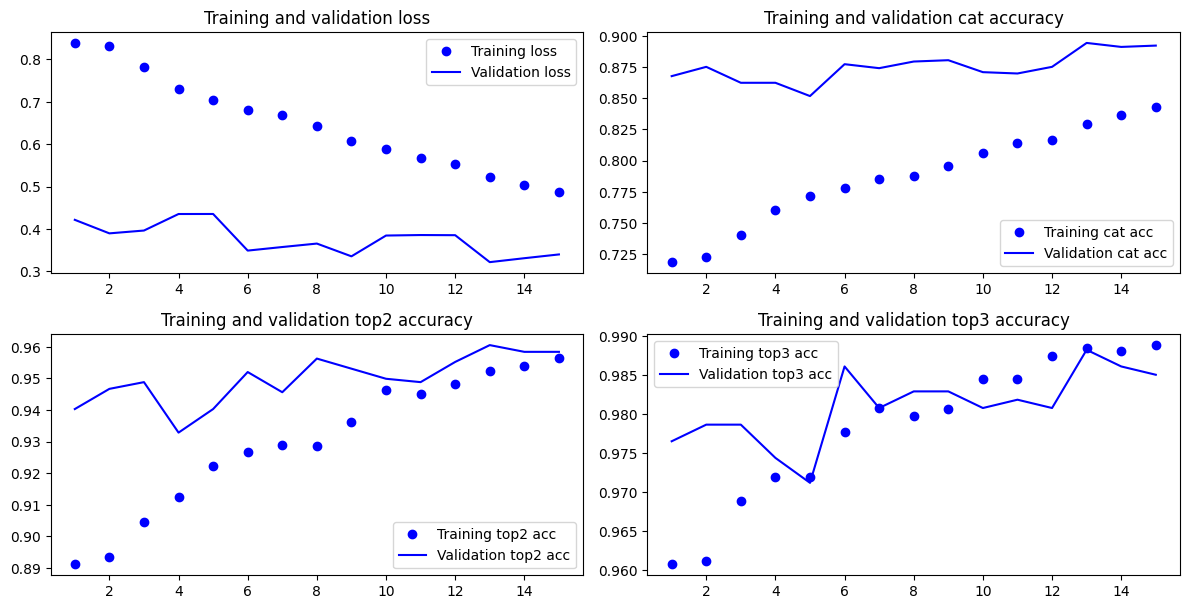

In [ ]:
plt.figure(figsize=(12, 12))

# Plot training and validation accuracy

acc = base_history['categorical_accuracy']
val_acc = base_history['val_categorical_accuracy']
loss = base_history['loss']
val_loss = base_history['val_loss']
train_top2_acc = base_history['top_2_accuracy']
val_top2_acc = base_history['val_top_2_accuracy']
train_top3_acc = base_history['top_3_accuracy']
val_top3_acc = base_history['val_top_3_accuracy']
epochs = range(1, len(acc) + 1)

# Plot training and validation loss
plt.subplot(4, 2, 1)
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

# Plot training and validation categorical accuracy
plt.subplot(4, 2, 2)
plt.plot(epochs, acc, 'bo', label='Training cat acc')
plt.plot(epochs, val_acc, 'b', label='Validation cat acc')
plt.title('Training and validation cat accuracy')
plt.legend()

# Plot training and validation top2 accuracy
plt.subplot(4, 2, 3)
plt.plot(epochs, train_top2_acc, 'bo', label='Training top2 acc')
plt.plot(epochs, val_top2_acc, 'b', label='Validation top2 acc')
plt.title('Training and validation top2 accuracy')
plt.legend()

# Plot training and validation top3 accuracy
plt.subplot(4, 2, 4)
plt.plot(epochs, train_top3_acc, 'bo', label='Training top3 acc')
plt.plot(epochs, val_top3_acc, 'b', label='Validation top3 acc')
plt.title('Training and validation top3 accuracy')
plt.legend()

plt.tight_layout()
plt.show()

The decreasing training loss and increasing training accuracy suggest that the model is effectively learning from the training data. However, the stagnant or fluctuating validation loss and accuracy indicate a lack of generalization to the validation set. This divergence suggests that the model is too complex or is fitting noise in the training data, leading to poor performance on new, unseen examples.

The observed discrepancy between training and validation metrics may indicate potential overfitting during model training. Overfitting occurs when the model becomes too specialized in learning the training data, capturing noise and details that may not generalize well to new, unseen data.



## **Optimizing the Model**

To enhance the model's training performance and generalization capabilities I implemented several optimization techniques:


* **Learning Rate Scheduler:**
Incorporated a learning rate scheduler to dynamically adjust the learning rate during training. This adaptive strategy helps prevent overshooting and oscillations, allowing the model to converge more efficiently.

* **Extended Training Epochs:**
Extended the number of training epochs from the initial setting to 30. This decision allows the model to undergo more iterations, potentially capturing intricate patterns and improving overall performance. However, it's crucial to monitor for signs of overfitting during the extended training duration.

* **Hyperparameter Tuning:**
Conducted hyperparameter tuning, specifically focusing on optimizing the learning rate (lr_rate) and dropout rate. Fine-tuning these parameters involves iterative experimentation to identify the values that yield the best model performance. A systematic exploration of hyperparameter space ensures that the model finds an optimal configuration for the given task.





In [ ]:
# Specify the path for saving the optimized model
save_model_path = '/content/drive/My Drive/skincancer/finaltrain/optimisedmodel121.h5'

# Configure ModelCheckpoint to save the best model based on validation top-3 accuracy
ck =  ModelCheckpoint(save_model_path, monitor='val_top_3_accuracy', verbose=1, save_best_only=True, mode='max')

# Introduce a learning rate scheduler to improve the model
reduce_lr = ReduceLROnPlateau(monitor='val_top_3_accuracy', factor=0.5, patience=2, verbose=1, mode='max', min_lr=0.00001)

optimised_call_backs = [reduce_lr, ck]


STEP_SIZE_TRAIN = num_train_samples//train_batch_size
STEP_SIZE_VALID = num_val_samples//val_batch_size

In [ ]:
# Define the hypermodel function with HyperParameters
def build_model(hp):
    return baseline_model(
        input_size=image_shape,
        num_classess=hyper_param['num_class'],
        pretrained_model=hyper_param['backbone_model'],
        model_name=hyper_param['save_final_model'],
        lr_rate = hp.Float('learning_rate', min_value=1e-6, max_value=1e-1, sampling='log', default=1e-3),
        dropout_rate=hp.Float('dropout_rate', min_value=0.2, max_value=0.5, step=0.1, default=0.2)
    )

# Instantiate the tuner and perform the search
tuner = RandomSearch(
    build_model,
    objective=keras_tuner.Objective('val_top_3_accuracy', direction='max'),
    max_trials=3,
    project_name='hyperparameter_tuning'
)

# Perform hyperparameter search using the tuner
tuner.search(
    train_generator,
    epochs=30,
    validation_data=validation_generator,
    steps_per_epoch=STEP_SIZE_TRAIN,
    validation_steps = STEP_SIZE_VALID,
    batch_size = hyper_param['train_batch_size'],
    class_weight = class_weights,
)


# Retrieve the best hyperparameters from the tuner
best_hps = tuner.oracle.get_best_trials(num_trials=1)[0].hyperparameters

# Create a new model using the best hyperparameters
optimised_model = baseline_model(
    input_size=image_shape,
    num_classess=hyper_param['num_class'],
    pretrained_model=hyper_param['backbone_model'],
    model_name=hyper_param['save_final_model'],
    lr_rate=best_hps.Choice('learning_rate', values=[1e-4, 1e-5, 1e-6, 3e-5], default=3e-5),
    dropout_rate=best_hps.Float('dropout_rate', min_value=0.2, max_value=0.5, step=0.1, default=0.5)
)


# Train and evaluate the best model
optimised_history = baseline_model.fit(
                      train_generator,
                      epochs=30, #increased epoch
                      class_weights=class_weights,
                      validation_data=validation_generator,
                      steps_per_epoch=STEP_SIZE_TRAIN,
                      validation_steps=STEP_SIZE_VALID,
                      callbacks=optimised_call_backs,
                      verbose = 1,
)

Epoch 1/30
907/907 [==============================] - ETA: 0s - loss: 1.3195 - categorical_accuracy: 0.5022 - top_2_accuracy: 0.7135 - top_3_accuracy: 0.8498 - precision_2: 0.6393 - recall_2: 0.3377
Epoch 1: val_top_3_accuracy improved from -inf to 0.35376, saving model to /content/drive/My Drive/skincancer/finaltrain/optimisedmodel121.h5
907/907 [==============================] - 123s 135ms/step - loss: 1.3195 - categorical_accuracy: 0.5022 - top_2_accuracy: 0.7135 - top_3_accuracy: 0.8498 - precision_2: 0.6393 - recall_2: 0.3377 - val_loss: 12.4816 - val_categorical_accuracy: 0.1677 - val_top_2_accuracy: 0.2742 - val_top_3_accuracy: 0.3538 - val_precision_2: 0.1181 - val_recall_2: 0.0849 - lr: 0.0010
Epoch 2/30
907/907 [==============================] - ETA: 0s - loss: 1.1219 - categorical_accuracy: 0.5825 - top_2_accuracy: 0.7805 - top_3_accuracy: 0.8889 - precision_2: 0.7005 - recall_2: 0.4440
Epoch 2: val_top_3_accuracy improved from 0.35376 to 0.92581, saving model to /content/dr

In [ ]:
from tensorflow.keras.models import load_model
import pickle

# Save the optimised training history using pickle
with open('/content/drive/My Drive/skincancer/finaltrain/optimised_training_121.pkl', 'wb') as file:
    pickle.dump(optimised_history.history, file)

### **Evaluating the Optimised Model**





In [ ]:
from tensorflow.keras.models import load_model

save_model_path = '/content/drive/My Drive/skincancer/finaltrain/optimisedmodel121.h5'
# Define custom metri
def top_3_accuracy(y_true, y_pred):
    return top_k_categorical_accuracy(y_true, y_pred, k=3)

def top_2_accuracy(y_true, y_pred):
    return top_k_categorical_accuracy(y_true, y_pred, k=2)

custom_metrics = {
    'top_2_accuracy': top_2_accuracy,
    'top_3_accuracy': top_3_accuracy,
}

# Load the saved model
optimisedmodel = load_model(save_model_path, custom_objects=custom_metrics)

In [ ]:
optimisedmodel.metrics_names

['loss',
 'categorical_accuracy',
 'top_2_accuracy',
 'top_3_accuracy',
 'precision_2',
 'recall_2']

In [ ]:
def evaluate_model(model, test_generator, metrics):
    # Evaluate the model on the test set
    test_results = model.evaluate(test_generator, steps=len(test_generator))

    # Map metric names to their corresponding values
    metric_values = {metric_name: test_results[i] for i, metric_name in enumerate(model.metrics_names)}

    # Display the computed metric values
    for metric_name in metrics:
      value = metric_values[metric_name]
      formatted_value = f'{value:.5f}'
      print(f'{metric_name}: {formatted_value}')

    return metric_values

# Example usage:
# Assuming you have a test generator named 'test_generator' and the desired metrics list
metrics_list = ['loss', 'categorical_accuracy', 'top_2_accuracy', 'top_3_accuracy', 'precision_2', 'recall_2']

# Call the function to evaluate the model
evaluation_results = evaluate_model(optimisedmodel, test_generator, metrics_list)

938/938 [==============================] - 15s 14ms/step - loss: 0.2609 - categorical_accuracy: 0.9168 - top_2_accuracy: 0.9744 - top_3_accuracy: 0.9936 - precision_2: 0.9294 - recall_2: 0.8977
loss: 0.26086
categorical_accuracy: 0.91684
top_2_accuracy: 0.97441
top_3_accuracy: 0.99360
precision_2: 0.92936
recall_2: 0.89765



Achieved significant enhancements in the optimized model's performance compared to the baseline:

* Reduced loss to 0.26086, indicating improved overall predictive accuracy.
* Increased categorical accuracy to 91.68%, showcasing improved image classification capabilities.
* Improved top-2 and top-3 accuracies to 97.44% and 99.36%, respectively, demonstrating refined predictive capabilities.
* Achieved precision and recall values of 92.94% and 89.77%, emphasizing precise predictions and reduced false negatives.

 ## **Visualisation of optimised model's performance**

In [ ]:
# Load the training history using pickle
from tensorflow.keras.models import load_model
import pickle
with open('/content/drive/My Drive/skincancer/finaltrain/optimised_training_121.pkl', 'rb') as file:
    optimised_history = pickle.load(file)

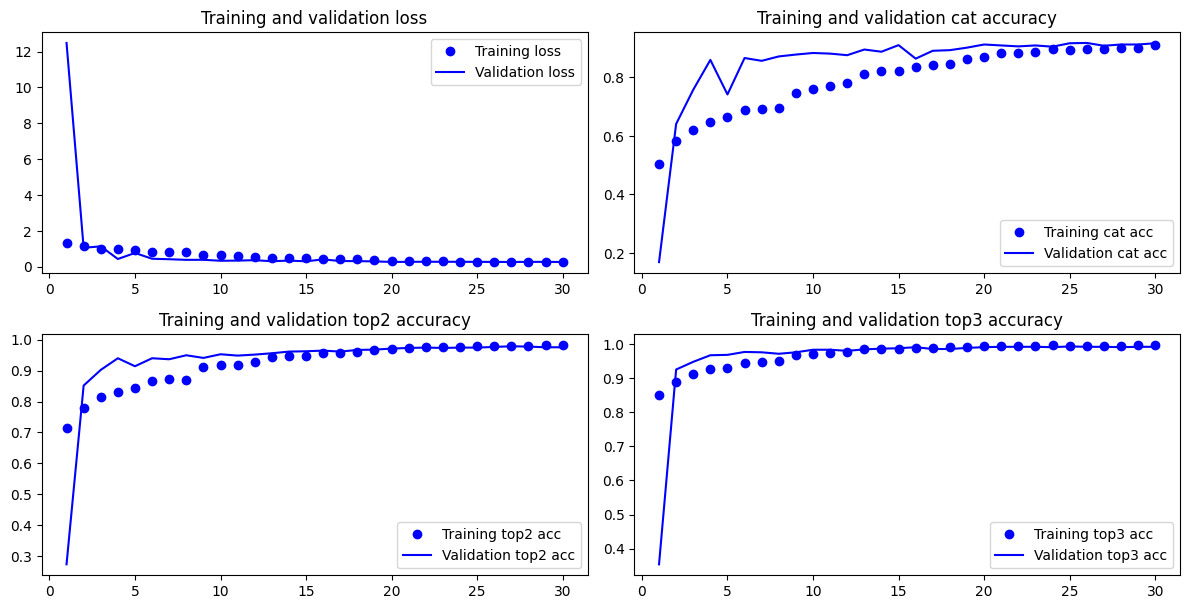

In [ ]:
plt.figure(figsize=(12, 12))

# Plot training and validation accuracy

acc = optimised_history['categorical_accuracy']
val_acc = optimised_history['val_categorical_accuracy']
loss = optimised_history['loss']
val_loss = optimised_history['val_loss']
train_top2_acc = optimised_history['top_2_accuracy']
val_top2_acc = optimised_history['val_top_2_accuracy']
train_top3_acc = optimised_history['top_3_accuracy']
val_top3_acc = optimised_history['val_top_3_accuracy']
epochs = range(1, len(acc) + 1)

# Plot training and validation loss
plt.subplot(4, 2, 1)
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

# Plot training and validation categorical accuracy
plt.subplot(4, 2, 2)
plt.plot(epochs, acc, 'bo', label='Training cat acc')
plt.plot(epochs, val_acc, 'b', label='Validation cat acc')
plt.title('Training and validation cat accuracy')
plt.legend()

# Plot training and validation top2 accuracy
plt.subplot(4, 2, 3)
plt.plot(epochs, train_top2_acc, 'bo', label='Training top2 acc')
plt.plot(epochs, val_top2_acc, 'b', label='Validation top2 acc')
plt.title('Training and validation top2 accuracy')
plt.legend()

# Plot training and validation top3 accuracy
plt.subplot(4, 2, 4)
plt.plot(epochs, train_top3_acc, 'bo', label='Training top3 acc')
plt.plot(epochs, val_top3_acc, 'b', label='Validation top3 acc')
plt.title('Training and validation top3 accuracy')
plt.legend()

plt.tight_layout()
plt.show()

The visualizations of training and validation metrics exhibit a notable improvement in the optimized model compared to the baseline. Both training and validation loss curves converge smoothly, reaching their lowest points together. Similarly, the accuracy curves for both training and validation sets also converge, achieving their highest points simultaneously. This convergence suggests a significant enhancement in model generalization, as the performance on unseen data aligns closely with the performance on the training set. These cohesive trends indicate a more stable and reliable model, demonstrating improved learning and predictive capabilities.

## **Confusion Matrix of Optimised Model**

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import itertools

In [ ]:
# Get the labels of the test images
test_labels = test_generator.classes

In [ ]:
test_labels

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3,
       3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,

In [ ]:
len(df_val)

938

In [ ]:
# Generate Predictions using the Optimized Model
# Use the predict_generator method to generate predictions on the test dataset
predictions = optimisedmodel.predict_generator(test_generator, steps=len(df_val), verbose=1)

<ipython-input-64-e0641e78aa56>:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  predictions = optimisedmodel.predict_generator(test_generator, steps=len(df_val), verbose=1)


938/938 [==============================] - 16s 15ms/step


In [ ]:
predictions.shape

(938, 7)

In [ ]:
# Confusion Matrix Plotting Function

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """

    # Check if normalization is required
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    # Plot the confusion matrix
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    # Display values in each cell
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout(h_pad=2, w_pad=2)

In [ ]:
# Use the confusion_matrix function to calculate the confusion matrix
cm = confusion_matrix(test_labels, predictions.argmax(axis=1))

In [ ]:
test_generator.class_indices

{'akiec': 0, 'bcc': 1, 'bkl': 2, 'df': 3, 'mel': 4, 'nv': 5, 'vasc': 6}

Confusion matrix, without normalization
[[ 17   1   4   0   1   3   0]
 [  1  28   0   0   0   1   0]
 [  3   0  49   2   8  13   0]
 [  0   0   0   3   0   3   0]
 [  0   0   4   0  21  14   0]
 [  0   1   7   2   7 734   0]
 [  0   0   0   0   1   2   8]]


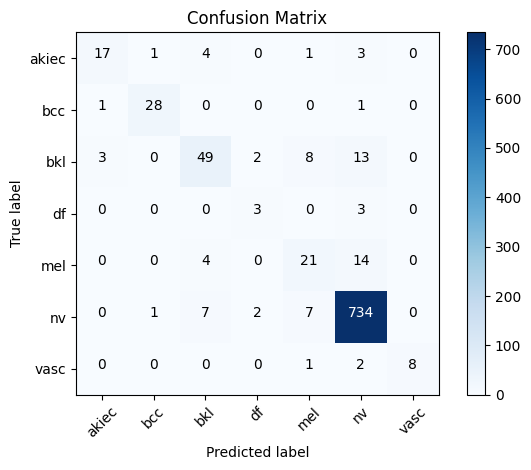

In [ ]:
# Define the labels of the class indices. These need to match the order shown above.
cm_plot_labels = ['akiec', 'bcc', 'bkl', 'df', 'mel','nv', 'vasc']

plot_confusion_matrix(cm, cm_plot_labels, title='Confusion Matrix')

## **Generate the Classification Results**

In [ ]:
# Get the index of the class with the highest probability score
y_pred = np.argmax(predictions, axis=1)

# Get the labels of the test images.
y_true = test_generator.classes

In [ ]:
from sklearn.metrics import classification_report

# Generate a classification report
report = classification_report(y_true, y_pred, target_names=cm_plot_labels)

print(report)

              precision    recall  f1-score   support

       akiec       0.81      0.65      0.72        26
         bcc       0.93      0.93      0.93        30
         bkl       0.77      0.65      0.71        75
          df       0.43      0.50      0.46         6
         mel       0.55      0.54      0.55        39
          nv       0.95      0.98      0.97       751
        vasc       1.00      0.73      0.84        11

    accuracy                           0.92       938
   macro avg       0.78      0.71      0.74       938
weighted avg       0.91      0.92      0.91       938



The classification results demonstrate the effectiveness of the optimized model on the test set. With an overall accuracy of 92%, the model showcases robust performance across multiple skin cancer classes. Specific highlights include high precision values for the 'bcc' and 'nv' classes, indicating the model's ability to accurately identify these conditions. Additionally, improvements in recall and precision for various classes, such as 'akiec' and 'mel,' contribute to the model's balanced performance. The weighted average F1-score of 91% underscores the model's proficiency in achieving a harmonious blend of precision and recall across diverse skin cancer categories. Overall, these results signify the successful deployment of the model for skin cancer classification, demonstrating its potential for real-world applications.